# Behaviour Cloning - Self Driving Car

### Plan and progress till now :
1. Understand the complete project - **COMPLETE**
2. Download simulator and create dataset - **COMPLETE**
3. Train using same architecture and replicate same results - **COMPLETE**
[my result1 video](https://youtu.be/lmWiMkN3RaA)
4. Change model architecture ( use winograd and skip connections ) and re-train and get the results - **COMPLETE**
[my result2 video](https://youtu.be/LPsgquPTNbc)
5. Do documentation, explaination and compile results - **COMPLETE**

- We could use track 2 to train and track 1 to test. This should be much better as track 2 is hilly terrain and difficult to ride even for real users.


## Objective
To train a deep neural network using winograd convolution and skip connections for autonomous driving car on simulator. **It should generalize the network for driving on multiple tracks (unseen track)**

## Datasets
We wil be using a self driving car simulator to create the dataset. Here by using the simulator we will first actually drive and capture our driving behavior in the form of images and logs csv files(this will be taken care by simulator). 

Download the simulator from below link 
[A self-driving car simulator built with Unity @UDACITY](https://github.com/udacity/self-driving-car-sim)

The simulator will take care of generating images and log files. We do not need to write any code for it. We just need to drive. After building the model, we will again use the simulator to validate our model - whether it has learned to control the steering by seeing the real time images or not.


#### How to Use Simulator
* Select Training mode
* Click on recording and choose the folder where you want to save the files
* Drive using arrow keys 
* Stop the recording

Check the folder for center, left and right camera images

Check for log file, driving_log.csv -
* First three columns are name and path of images stored for center, left and right cameras at a particular instance
* Forth column is steering angle followed by throttle, brake and speed.

#### NOTE :
Use only the **left side track ( Track 1 ) to create dataset for training**. Right side of track should be used for testing purpose. No image or data log should be seen for right side track.


Before and after shadow addition

Different types of random 
- np.random.premutation
- np.random.randint
- np.random.choice
- random.uniform


In [97]:
import os # to change directory, set path etc
import pandas as pd # to work with csv files, dataframe - relational or labeled data, perform data analysis 
import numpy as np # sophisticated broadcasting functions, random number generation - multidimentional array
import matplotlib.pyplot as plt # display images  - can use io from skimage also

import skimage.transform as sktransform # for image pre-processing 
import random
import matplotlib.image as mpimg # read image

from keras.callbacks import Callback # to capture statistics of the model during training
import shutil # copying or removal - to flush entire directory if it exists before we start logging trained weights

import tensorflow as tf # 
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling, BatchNormalization
from sklearn import model_selection
#from data import generate_samples, preprocess
#from weights_logger_callback import WeightsLogger

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

local_project_path = 'D:/AI/2018/Inkers/Session/Proj1'
local_data_path = os.path.join(local_project_path, 'ride1')
os.chdir('D:/AI/2018/Inkers/Session/Proj1')

### Read the log file

We would first start by looking at the log csv file generated by simulator.


In [60]:
df = pd.read_csv('ride1/driving_log.csv')
df.head(10)

,center,left,right,steering,throttle,brake,speed
0,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,0.00,0.000000,0,0.000014
1,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,0.00,0.000000,0,0.000006
2,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,0.00,0.277551,0,0.167749
3,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,0.00,0.507935,0,0.563577
4,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,-0.15,0.737132,0,1.178612
5,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,-0.35,0.962928,0,2.003867
6,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,-0.50,1.000000,0,2.707505
7,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,-0.70,1.000000,0,3.615764
8,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,-0.90,1.000000,0,4.501734
9,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,-1.00,1.000000,0,5.364134


### Understanding Target variable
**Steering angle** is our target variable which we need to predict so first thing which we need to check is how the distribution of steering angle looks like in our data.

Steering angle ranges from -1 to 1 but we would take absolute value (-0.5 is depicting left and 0.5 right). This is because we are interested in seeing how many data points are there for range of steering angles. 

We can also flip images and negate their steering angles while training.

(array([38159.,  3049.,  3515.,   657.,   766.,   439.,   354.,    60.,
           73.,    73.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

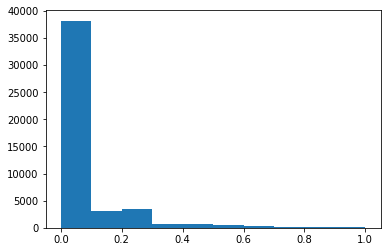

In [61]:
plt.hist(np.absolute(df.steering))

We see that most of the data point lies near to zero. This is true because most of the time during driving we are not turning the steering left or right.

**#P1** : If we train on raw data we would be giving more of zero angle data points and straight road images to learn. The model will focus on learning this easy task. Accuracy would be biased on majority data points (here straight row and near to zero steering angle). We want to make the DNN learn difficult situation and genaralize to other tracks. We would like to make our model smart so we need to create balanced dataset.

**Composing the training dataset is most crucial**

We will bin the values of steering angles (-1, 1) into **bins** and for each bin we would try to get at max **bin_n** images.

For bins = 40 and bin_n = 1000, I felt good amount of image pouring in till 0.35 angle. Saying that we can still try reducing or increasing bin_n (or bins). We can also look on std deviation of balanced data steering angle and decide optimum value for bins and bin_n.

In [106]:
balanced = pd.DataFrame() # empty balanced dataset
bins = 40                 # number of bins
bin_n = 500              # number of examples images to include in each bin (at most)


start = 0
for end in np.linspace(0, 1, num=bins):  
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if(range_n> 0):
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end


In [107]:
balanced.shape # total images in balanced set

(5732, 7)

0.3091019316085776

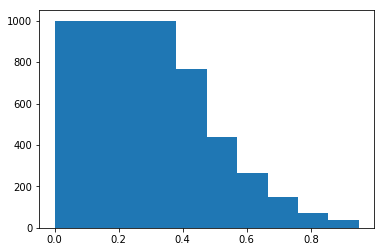

In [108]:
plt.hist(np.absolute(balanced.steering))
np.std(balanced.steering)


After filtering images, we can see that we have around 1000 images having steering angle upto 0.5 in each bin. Lets write this data frame to a file for later use.

In [109]:
balanced.to_csv('ride1/driving_log_balanced.csv', index=False)

### How raw images look like?

Lets pull up images from all three cameras for an instance (one row - one frame) and see how they look like and what's the shape of raw image. For adjusted camera angles we will see later in Image prerocessing section.

Actual steering angle =  0.0


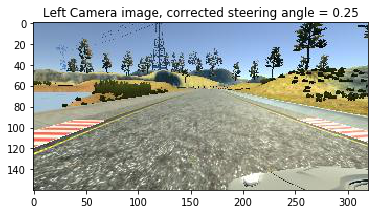

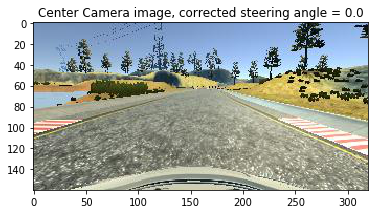

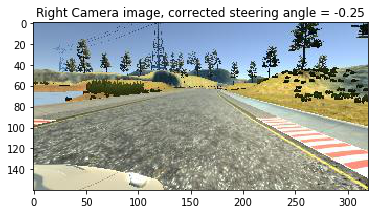

In [120]:
os.getcwd()
df = pd.io.parsers.read_csv(os.path.join(local_data_path, 'driving_log_balanced.csv'))
list(df)
i=1
print('Actual steering angle = ',df['steering'].values[i])
left_image = mpimg.imread(os.path.join( df['left'].values[i]))
center_image = mpimg.imread(os.path.join( df['center'].values[i]))
right_image = mpimg.imread(os.path.join( df['right'].values[i]))
plt.imshow(left_image)
plt.title('Left Camera image, corrected steering angle = '+ str(df['steering'].values[i] + 0.25))
plt.show()
plt.imshow(center_image)
plt.title('Center Camera image, corrected steering angle = '+ str(df['steering'].values[i] + 0))
plt.show()
plt.imshow(right_image)
plt.title('Right Camera image, corrected steering angle = '+ str(df['steering'].values[i] - 0.25))
plt.show()

In [121]:
df.iloc[[i]] #iloc operator to explicity support only integer indexing

,center,left,right,steering,throttle,brake,speed
1,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\cent...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\left...,D:\AI\2018\Inkers\Session\Proj1\ride1\IMG\righ...,0.0,1.0,0,30.19029


### Image pre-processing

**Now we would think why 3 cameras images ?**

We get three different images from three different cameras at the same instance. And in order to make our model robust we must utilize the images from all three cameras. This will also increase observable view area to make decision for steering angle.

As we have seen the images from left and right cameras are at some angle and if we want to use all cameras images and steering angle associated with it, as it is then it would be wrong. 

At a same instance images from left camera would see a turning road but center camera image might show a straight road. So there is a need to adjust the steering angle associated with left and right camera images. Thus we can adjust steering angles for left and right camera images and use for training purpose along with center images.

Plus/minus 0.25 is taken as most of the previous users recommended using this value. They have already tried different values so I would not spend more time experimet with this number. But we must note importance of using all 3 camera images.

**Benefit of using all 3 cameras images ?**
- Increase in training dataset with |steering angles| > 0.25 ( Let DNN learn difficult situations :D )
- At an instance on a straight path , say we have 3 images  : (example image shown above) by just looking at left image we would say to turn steering right , similarly with right image we would say to turn steering left but actually with center camera we do not feel the need to change steering.

**Adding Shadow **

Track 2 (right track) has shadows and hilly terrain so we must augment our training images with shadow in order to generalize to other tracks. We an also try other things like adding **salt and pepper** which might work for **rainy day** track.

**Cropping **

Top part of image would mostly have sky and some scene which is not useful and would just add noise. And our DNN might learn from those noise. We rather be interested in just the road track. So we should employ cropping. 

Here we crop the image from top by using the value of top_offset and bottom of image by bottom offset.
and again resizes the image to 32X128X3


In [122]:
# Cameras we will use
cameras = ['left', 'center', 'right']
cameras_steering_correction = [.25, 0., -.25] 

def preprocess(image, top_offset=.375, bottom_offset=.125):
    """
    Applies preprocessing pipeline to an image: crops `top_offset` and `bottom_offset`
    portions of image, resizes to 32x128 px and scales pixel values to [0, 1].
    """
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = sktransform.resize(image[top:-bottom, :], (32, 128, 3))
    return image

def generate_samples(data, root_path, augment=True):
    """
    Keras generator yielding batches of training/validation data.
    Applies data augmentation pipeline if `augment` is True.
    """
    while True:
        # Generate random batch of indices
        indices = np.random.permutation(data.count()[0])
        batch_size = 128
        for batch in range(0, len(indices), batch_size):
            batch_indices = indices[batch:(batch + batch_size)]
            # Output arrays
            x = np.empty([0, 32, 128, 3], dtype=np.float32)
            y = np.empty([0], dtype=np.float32)
            # Read in and preprocess a batch of images
            for i in batch_indices:
                # Randomly select camera
                camera = np.random.randint(len(cameras)) if augment else 1
                # Read frame image and work out steering angle
                image = mpimg.imread(os.path.join(root_path, data[cameras[camera]].values[i].strip()))
                image = image.copy()
                #image = colors.rgb_to_hsv(image)
                angle = data.steering.values[i] + cameras_steering_correction[camera]
                if augment:
                    # Add random shadow as a vertical slice of image
                    h, w = image.shape[0], image.shape[1]
                    [x1, x2] = np.random.choice(w, 2, replace=False)
                    k = h / (x2 - x1)
                    b = - k * x1
                    for i in range(h):
                        c = int((i - b) / k)
                        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
                # Randomly shift up and down while preprocessing
                v_delta = .05 if augment else 0
                image = preprocess(
                    image,
                    top_offset=random.uniform(.375 - v_delta, .375 + v_delta),
                    bottom_offset=random.uniform(.125 - v_delta, .125 + v_delta)
                )
                #image = colors.rgb_to_hsv(image)
                # Append to batch
                x = np.append(x, [image], axis=0)
                y = np.append(y, [angle])
            # Randomly flip half of images in the batch
            flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
            x[flip_indices] = x[flip_indices, :, ::-1, :]
            y[flip_indices] = -y[flip_indices]
            yield (x, y)

### Experimenting with other transformations

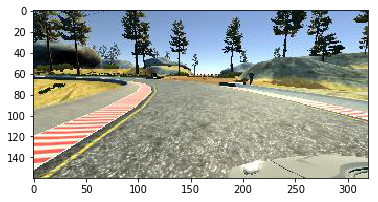

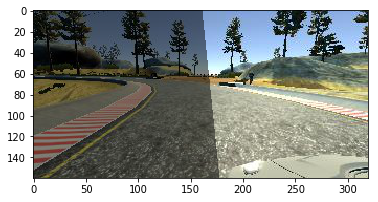

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


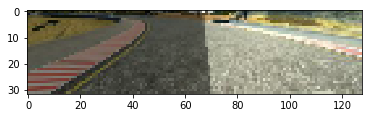

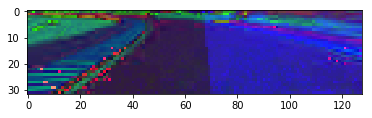

In [126]:
image = mpimg.imread(os.path.join( df['left'].values[i]))
image = image.copy()
plt.imshow(image)
plt.show()

# Add random shadow as a vertical slice of image
h, w = image.shape[0], image.shape[1]
[x1, x2] = np.random.choice(w, 2, replace=False)
k = h / (x2 - x1)
b = - k * x1
for i in range(h):
    c = int((i - b) / k)
    image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)

plt.imshow(image)
plt.show()

image = preprocess( image, top_offset=random.uniform(.375 , .375 )
                            , bottom_offset=random.uniform(.125 , .125 ) )
plt.imshow(image)
plt.show()

from matplotlib import colors
image = colors.rgb_to_hsv(image)
plt.imshow(image)
plt.show()


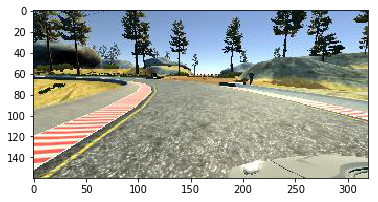

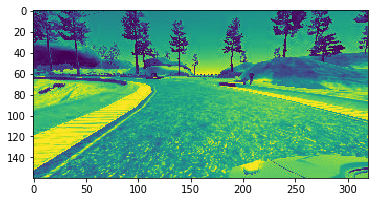

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


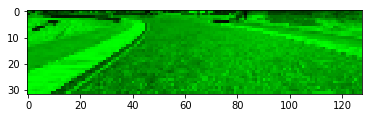

In [128]:
left_image = mpimg.imread(os.path.join( df['left'].values[i]))
plt.imshow(left_image)
plt.show()

lum_img1 = left_image[:,:,0]
#lum_img1 = sktransform.resize(lum_img1, (32, 128, 3))
plt.imshow(lum_img1)
plt.show()

after_cropping = preprocess( lum_img1, top_offset=random.uniform(.375 , .375 )
                            , bottom_offset=random.uniform(.125 , .125 ) )
plt.imshow(after_cropping)
plt.show()


In [115]:
class WeightsLogger(Callback):
    """
    Keeps track of model weights by saving them at the end of each epoch.
    A callback has access to its associated model through the class property self.model.
    By making use of self.model.save_weights() we will save the weights learned at each epoch
    """

    def __init__(self, root_path):
        super(WeightsLogger, self).__init__()
        self.weights_root_path = os.path.join(root_path, 'weights/')
        shutil.rmtree(self.weights_root_path, ignore_errors=True)
        os.makedirs(self.weights_root_path, exist_ok=True)

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.weights_root_path, 'model_epoch_{}.h5'.format(epoch + 1)))


### Reduce the parameters to be learned
We would be using Winograd Conv

This type of convolution utilizes the fact that a square matrix is a dot product of two other simpler 1-D matrix. See an example below -

![](https://image.slidesharecdn.com/2filters-170112120805/95/computer-vision-image-filters-21-638.jpg?cb=1484223002)

So, if we had to perform convolution of $28X28$ image by $3X3$ kernel we would have 9 parameters to learn. But if we convolve with $3X1$ and then by $1X3$  we will have the same effect and total number of parametes would also reduce to 6 instead of 9.


In [116]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(local_data_path, 'driving_log_balanced.csv'))
# Split data into training and validation sets
df_train, df_valid = model_selection.train_test_split(df, test_size=.0)

# using validation from another track - to see whether all image transformations and neural net architecture 
# is working for unseen track also or not
df_valid = pd.io.parsers.read_csv('D:/AI/2018/Inkers/Session/Proj1/ride3/driving_log_balanced.csv')
    
    
from keras.layers import merge, Conv2D, Input, Flatten, Activation, MaxPooling2D, Dense, Add
from keras.models import Model
    
input_img = Input(shape=(32, 128, 3))
x1 = Conv2D(32, (3, 1), activation='relu' , padding='same')(input_img)
x2 = Conv2D(32, (1, 3), activation='relu' , padding='same')(x1)
x2 = MaxPooling2D((2, 2), padding='same')(x2)

x21 = core.Dropout(.5)(x2)

x3 = Conv2D(32, (3, 1), activation='relu' , padding='same')(x21)
x4 = Conv2D(32, (1, 3), activation='relu' , padding='same')(x3)

x4 = Add()([x2, x4])
x4 = MaxPooling2D((2, 2), padding='same')(x4)

x5 = Conv2D(64, (3, 1), activation='relu' , padding='same')(x4)
x6 = Conv2D(64, (1, 3), activation='relu' , padding='same')(x5)
x6 = MaxPooling2D((2, 2), padding='same')(x6)

x61 = Conv2D(128, (3, 1), activation='relu' , padding='same')(x6)
x61 = Conv2D(128, (1, 3), activation='relu' , padding='same')(x61)
x61 = MaxPooling2D((2, 2), padding='same')(x61)

x62 = Conv2D(64, (1, 1), activation='relu' , padding='same')(x61)
x62 = Conv2D(32, (1, 1), activation='relu' , padding='same')(x61)
x62 = MaxPooling2D((2, 2), padding='same')(x62)

x7 = Flatten()(x62)

x7 = core.Dropout(.5)(x7)

x8 = Dense(50, activation='relu' )(x7)

op_layers = Dense(1)(x8)

model = Model(input_img, op_layers)
print(model.summary())

model.compile(optimizer=optimizers.Adam(lr=1e-04), loss='mean_squared_error')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 128, 32)  320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 128, 32)  3104        conv2d_62[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 16, 64, 32)   0           conv2d_63[0][0]                  
__________________________________________________________________________________________________
dropout_13

Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.

In [118]:
history = model.fit_generator(
    generate_samples(df_train, local_data_path),
    steps_per_epoch=df_train.shape[0]/128,    # steps_per_epoch = samples_per_epoch / batch_size
    nb_epoch=30,
    validation_data = generate_samples(df_valid, local_data_path, augment=False),
    callbacks = [WeightsLogger(root_path=local_project_path)],
    validation_steps = df_valid.shape[0]/128,
)

with open(os.path.join(local_project_path, 'model.json'), 'w') as file:
    file.write(model.to_json())

#backend.clear_session()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=44.78125, validation_data=<generator..., callbacks=[<__main__..., validation_steps=2.59375, epochs=30)`
  import sys
C:\Users\Admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be cha

Epoch 1/30
45/44 [==============================] - 80s 2s/step - loss: 0.0810 - val_loss: 0.2113
Epoch 2/30
45/44 [==============================] - 77s 2s/step - loss: 0.0754 - val_loss: 0.2127
Epoch 3/30
45/44 [==============================] - 76s 2s/step - loss: 0.0741 - val_loss: 0.2094
Epoch 4/30
45/44 [==============================] - 77s 2s/step - loss: 0.0716 - val_loss: 0.2089
Epoch 5/30
45/44 [==============================] - 77s 2s/step - loss: 0.0692 - val_loss: 0.2153
Epoch 6/30
45/44 [==============================] - 76s 2s/step - loss: 0.0688 - val_loss: 0.2112
Epoch 7/30
45/44 [==============================] - 78s 2s/step - loss: 0.0679 - val_loss: 0.2093
Epoch 8/30
45/44 [==============================] - 77s 2s/step - loss: 0.0662 - val_loss: 0.2039
Epoch 9/30
45/44 [==============================] - 78s 2s/step - loss: 0.0634 - val_loss: 0.2160
Epoch 10/30
45/44 [==============================] - 78s 2s/step - loss: 0.0629 - val_loss: 0.2181
Epoch 11/30
45/44 [

Now to test the results -
We would be use the below code which would help communicate with the simualator.

- Make sure the app is opened and you have selected the track and then click on autonomous mode
- Run the below code to load the saved model json file and load the weights saved in .h5 file

In [ ]:
import base64

import numpy as np
import socketio
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

In [ ]:
from keras.models import model_from_json
import warnings

import tensorflow as tf
tf.python.control_flow_ops = tf

from data import preprocess

sio = socketio.Server()
app = Flask(__name__)
model = None
prev_image_array = None


@sio.on('telemetry')
def telemetry(sid, data):
    # The current steering angle of the car
    steering_angle = data["steering_angle"]
    # The current throttle of the car
    throttle = data["throttle"]
    # The current speed of the car
    speed = data["speed"]
    # The current image from the center camera of the car
    imgString = data["image"]
    image = Image.open(BytesIO(base64.b64decode(imgString)))
    image_array = preprocess(np.asarray(image))
    transformed_image_array = image_array[None, :, :, :]
    steering_angle = float(model.predict(transformed_image_array, batch_size=1))
    throttle = .2 if float(speed) > 5 else 1.
    print(steering_angle, throttle)
    send_control(steering_angle, throttle)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)


def send_control(steering_angle, throttle):
    sio.emit("steer", data={
        'steering_angle': steering_angle.__str__(),
        'throttle': throttle.__str__()
    }, skip_sid=True)


Use below code to read the saved model and load its weights. 

In [ ]:
json_file = open('D:/AI/2018/Inkers/Session/Proj1/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("D:/AI/2018/Inkers/Session/Proj1/weights/model_epoch_5.h5")
model.compile("adam", "mse")

# wrap Flask application with engineio's middleware
app = socketio.Middleware(sio, app)

# deploy as an eventlet WSGI server
eventlet.wsgi.server(eventlet.listen(('', 4567)), app)